In [1]:
import matplotlib.pyplot as plt
import numpy as np
import imageio
from scipy.linalg import expm

In [2]:
#Here we consider the pump moving from lab to crystal back to lab, i.e. we take the velocity to be z-dependent. In momentum space the EoMs can be readily solved by matrix exponention
#Maybe write up a quick note to show how you do it.

In [21]:
vp = 0.1  # pump velocity
c = 1  #speed of light which I take to be one
l = 1.0  # amplification region length
sig = 10  # pump wave packet spread
a = 1.61 / 1.13  # from symmetric grp vel matching

nk=800
k_ft = 200/l
dk = k_ft/nk
k = np.arange(-k_ft/2,k_ft/2,dk)

In [22]:
#Matrix responsible for time evolution, tyring it differently so that 'k' multiplies the FT before..
A = -1j*c*np.diag(k)-1j*(vp-c)*l*np.sinc(-(k-k[:,np.newaxis]*l/(2*np.pi)))*k/(2*np.pi)


In [5]:
#This is for considering GVD, just to see if Im plotting things correctly
A2 = -1j*c*np.diag(k)-1j*0.005*np.diag(k**2)

In [23]:
# defining gaussian pump pulse at t0 when it is outside the crystal
def pump(x, scale=1):
    return np.exp(-((x) ** 2) / (2 * ((c/sig)*scale) ** 2)) / np.power(np.pi * ((c/sig)*scale), 1 / 4)

Lambda =lambda x,t: pump(x+l-c*t,scale=1)

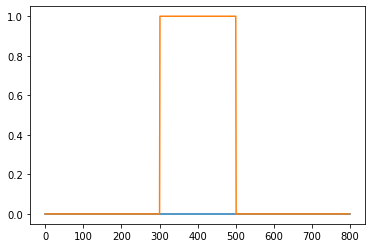

In [24]:
#Plotting the pump pulse to make sure chosen values of z0 and tf are good (i.e. pulse is completely out of crystal before and after)
dz=0.005
zplot=np.arange(-2,2,dz)
hat = (np.heaviside(zplot+0.5,0)-np.heaviside(zplot-0.5,0))
plt.plot(Lambda(zplot,4))
plt.plot(hat)

In [25]:
#Finding fourier transform of pump pulse
FT = np.sum(np.exp(-1j*np.tensordot(k,zplot,axes=0))/np.sqrt(2*np.pi)*dz*Lambda(zplot,0),axis=1)

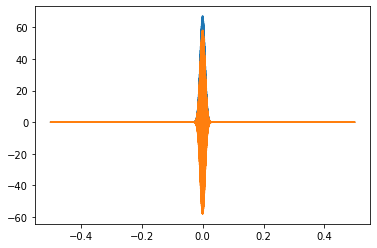

In [13]:
#Finding fourier transform using fft command.
ft = np.fft.fft(Lambda(zplot,0))
freq = np.fft.fftfreq(zplot.shape[-1])
plt.plot(freq, ft.real, freq, ft.imag)

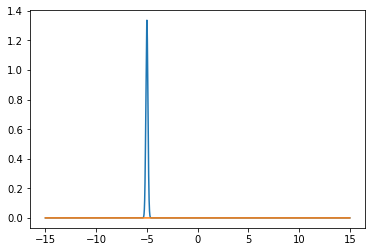

In [15]:
#Finding fourier transform using fft command.
ft2 = np.fft.ifft(np.fft.fft(Lambda(zplot,0)))
freq = np.fft.fftfreq(zplot.shape[-1])
plt.plot(zplot, ft2.real, zplot, ft2.imag)

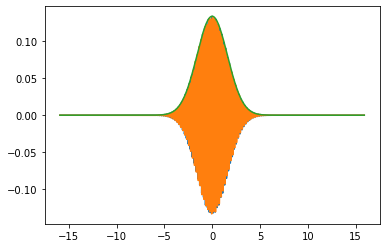

In [11]:
Evol = expm(A*0)@FT
plt.plot(k/(2*np.pi),np.real(Evol))
plt.plot(k/(2*np.pi),np.imag(Evol))
plt.plot(k/(2*np.pi),np.abs(Evol))

In [26]:
#This is if we keep the velocity constant
IFT = lambda t: np.sum(np.exp(1j*np.tensordot(zplot,k,axes=0))/np.sqrt(2*np.pi)*dk*(np.exp(-1j*c*k*t)*FT),axis=1) 

In [48]:
#This is if we keep the velocity constant and include small GVD
IFTgvd = lambda t: np.sum(np.exp(1j*np.tensordot(zplot,k,axes=0))/np.sqrt(2*np.pi)*dk*(np.exp(-1j*c*k*t-1j*0.005*(k**2)*t)*FT),axis=1) 

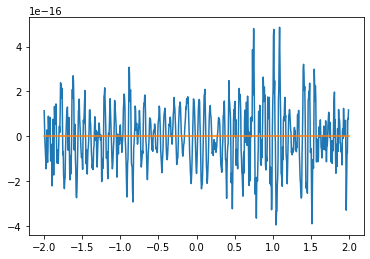

In [36]:
t=8
plt.plot(zplot,np.real_if_close(IFT(t)))
plt.plot(zplot,Lambda(zplot,t))

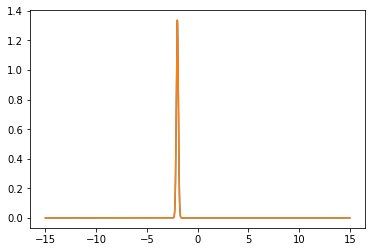

In [16]:
#Testing for weird periodicity
IFTnt=np.sum((FT*np.exp(1j*np.tensordot(zplot,k,axes=0)))*dk/np.sqrt(2*np.pi),axis=1)
plt.plot(zplot,np.real(IFTnt))
plt.plot(zplot,Lambda(zplot,0))
#plt.xlim(-2,0)

In [115]:
#Here I play with the momentum vector to get better inverse fourier transforms while being careful not to introduce periodicity
nk=2000*4
k_ft = 800/l
dk = k_ft/nk
k = np.arange(-k_ft/2,k_ft/2,dk)
A = -1j*c*np.diag(k)-1j*(vp-c)*l*np.sinc(-(k-k[:,np.newaxis]*l/(2*np.pi)))*k/(2*np.pi)
FT = np.sum(np.exp(-1j*np.tensordot(k,zplot,axes=0))/np.sqrt(2*np.pi)*dz*Lambda(zplot,0),axis=1)
IFT2 = lambda t: np.sum(np.exp(1j*np.tensordot(zplot,k,axes=0))/np.sqrt(2*np.pi)*dk*(expm(A*t)@(FT)),axis=1)
IFT = lambda t: np.sum(np.exp(1j*np.tensordot(zplot,k,axes=0))/np.sqrt(2*np.pi)*dk*(np.exp(-1j*c*k*t)*FT),axis=1) 


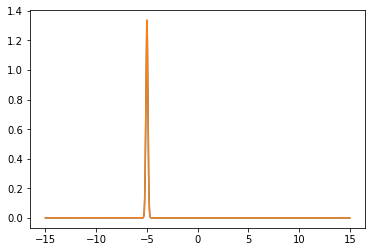

In [117]:
t=0
plt.plot(zplot,Lambda(zplot,t))
plt.plot(zplot,np.real(IFT(t)))

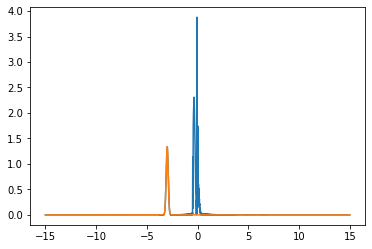

In [111]:
t=2
plt.plot(zplot,np.abs(IFT2(t)))
plt.plot(zplot,Lambda(zplot,t))
#plt.plot(hat)

In [118]:
t=2
plt.plot(k,np.real(expm(A*t)@(FT)))
plt.plot(k,np.imag(expm(A*t)@(FT)))

In [ ]:
#Need to do time evolution properly. By multipying by small steps dt..and then take fourier back. Try this kind of evol to see how it looks like.
t=np.arange(0,4,0.1)
FTevol=FT
for i in t:
    FTevol = expm(A*t)@(FTevol)



In [ ]:
IFT2 = np.sum(np.exp(1j*np.tensordot(zplot,k,axes=0))/np.sqrt(2*np.pi)*dk*(FTevol),axis=1)

In [ ]:
#Everything after this is for GIF purposes

In [56]:
def create_frame(t):
    fig, ax1 = plt.subplots()
    ax1.plot(zplot, np.abs(IFTgvd(t)), label='Pump') #Here we multiply by a phase factor such that the imaginary part is 0 at the origin.
    ax1.plot(zplot, hat, label='Crystal')
    ax1.set_ylim(-1.4, 1.4)
    ax1.set_xlabel(r"$z$")
    ax1.set_ylabel(r"$Amplitude$")
    ax1.set_title(r"$Blob animation$")
    ax1.legend()
    plt.savefig(f'img_{t}.png', 
                transparent = False,  
                facecolor = 'white'
               )
    plt.close()

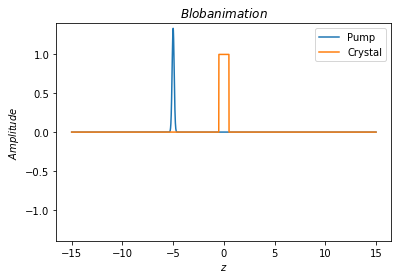

In [40]:
fig, ax1 = plt.subplots()
ax1.plot(zplot, np.abs(IFT(0)), label='Pump') #Here we multiply by a phase factor such that the imaginary part is 0 at the origin.
ax1.plot(zplot, hat, label='Crystal')
ax1.set_ylim(-1.4, 1.4)
ax1.set_xlabel(r"$z$")
ax1.set_ylabel(r"$Amplitude$")
ax1.set_title(r"$Blob animation$")
ax1.legend()
plt.show()

In [57]:
time = np.arange(0,10,0.5)

In [58]:
for t in time:
    create_frame(t)

In [59]:
frames = []
for t in time:
    image = imageio.v2.imread(f'img_{t}.png')
    frames.append(image)

In [60]:
imageio.mimsave('example.gif',frames, duration=100)         

In [69]:
#For what follows I am assuming v has some tanh shape to approximate the Heaviside functions. Doing so allows us to get a general solution
v1=1
v2=0.3
k3=100
zplot=np.arange(-2,2,dz)
Lambda2 = lambda x,t: pump((v1-v2)*np.log(v2*np.exp(2*k3*x)+v2)/(2*k3*v1*v2)+x/v1-t+1,scale=1)

In [72]:
np.vdot(Lambda2(zplot,0),Lambda2(zplot,0)),np.vdot(Lambda(zplot,0),Lambda(zplot,0)),np.vdot(Lambda(zplot,2),Lambda(zplot,2))

(63.24555320336894, 63.24555320336894, 63.24555320336894)

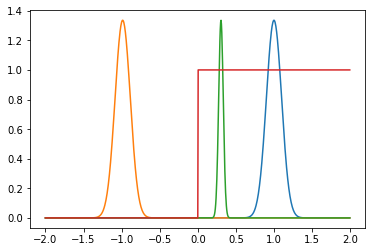

In [71]:
plt.plot(zplot,Lambda(zplot,2))
plt.plot(zplot,Lambda2(zplot,0))
plt.plot(zplot,Lambda2(zplot,2))
plt.plot(zplot,np.heaviside(zplot,0))

In [43]:
def create_frame(t):
    fig, ax1 = plt.subplots()
    ax1.plot(zplot, Lambda2(zplot,t), label='Pump') #Here we multiply by a phase factor such that the imaginary part is 0 at the origin.
    ax1.plot(zplot, np.heaviside(zplot,0), label='Crystal')
    ax1.set_ylim(-1.4, 1.4)
    ax1.set_xlabel(r"$z$")
    ax1.set_ylabel(r"$Amplitude$")
    ax1.set_title(r"$Blob animation$")
    ax1.legend()
    plt.savefig(f'img_{t}.png', 
                transparent = False,  
                facecolor = 'white'
               )
    plt.close()

In [50]:
time = np.arange(0,4.5,0.05)
for t in time:
    create_frame(t)

In [51]:
frames = []
for t in time:
    image = imageio.v2.imread(f'img_{t}.png')
    frames.append(image)

In [52]:
imageio.mimsave('example.gif',frames, duration=100)   